In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.sans-serif'] = ["simhei","Whitney Book"]
pd.set_option('display.precision', 2)

In [2]:
'''
链接：https://www.zhihu.com/question/29268904/answer/44402669
'''

# USAGE
# python color_kmeans.py --image images/jp.png --clusters 3
# Author: Adrian Rosebrock
# Website: www.pyimagesearch.com

# import the necessary packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2

def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

def array_rgb2hsv(rgbarray):
    narr = rgbarray.shape[0]
    retarr = np.zeros_like(rgbarray)
    for iarr in range(narr):
        h,s,v = rgb2hsv(rgbarray[iarr,0], 
                        rgbarray[iarr,1],
                        rgbarray[iarr,2])
        retarr[iarr,0] = h
        retarr[iarr,1] = s
        retarr[iarr,2] = v
    return retarr

def hsv2chn(hsvarr):
    hue = int(hsvarr[0])
    sat = hsvarr[1]
    bright = hsvarr[2]
    if(bright < 0.2):
        return '黑'
    elif(sat < 0.2 and bright > 0.8):
        return '白'
    if(hue in list(range(0,26))+list(range(321,361))):
        return '红'
    if(hue in list(range(26,31))):
        return '橙'
    if(hue in list(range(31,61))):
        return '黄'
    if(hue in list(range(61,131))):
        return '绿'
    if(hue in list(range(131,171))):
        return '青'
    if(hue in list(range(171,251))):
        return '蓝'
    if(hue in list(range(251,321))):
        return '紫'

def hsvs2chn(hsvs):
    hsvnm = []
    for hsv in hsvs:
        #print(hsv)
        hsvnm.append(hsv2chn(hsv))
    return hsvnm

def imgRecog(imgPath):
    '''
    输入图像，返回：
    1. 图像三主色（可能同色）；
    2. 主色比例（同色将会合并）；
    3. 图像饱和度；
    4. 图像亮度
    '''
    # load the image and convert it from BGR to RGB so that
    # we can display it with matplotlib
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # # show our image
    # plt.figure()
    # plt.axis("off")
    # plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = 3)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    image_hsv = array_rgb2hsv(clt.cluster_centers_)
    # output
    color_chn = np.array(hsvs2chn(image_hsv))
    main_color_ratio = sum(hist[color_chn==color_chn[np.argmax(hist)]])
    image_sat = sum(image_hsv[:,1]*hist)
    image_bri = sum(image_hsv[:,2]*hist)
    # image output
    #bar = plot_colors(hist, clt.cluster_centers_)
    # # show our color bar
    # plt.figure()
    # plt.axis("off")
    # plt.imshow(bar)
    # plt.show()
    
    return ''.join(color_chn), main_color_ratio, image_sat, image_bri


In [32]:
coupon = pd.read_csv('coupon_id_hot.csv',index_col=0,skiprows=1,names=['团购活动ID','是否爆款'])

In [4]:
pic = pd.DataFrame()
pic['所属团购ID'] = None
pic['图片主色'] = None
pic['图片主色比例'] = None
pic['图片饱和度'] = None
pic['图片亮度'] = None

In [5]:
import glob
from tqdm import tqdm

In [6]:
ikey = 0
for i in tqdm(range(len(coupon))):
    cid = coupon.iloc[i]['团购活动ID']
    flist = [filename for filename in glob.glob('data/pics/{0}*'.format(cid))][:3]
    if(len(flist)>0):
        for fnm in flist:
            pic.loc[ikey,'所属团购ID'] = cid
            pic.loc[ikey,'图片主色'], pic.loc[ikey,'图片主色比例'], pic.loc[ikey,'图片饱和度'], pic.loc[ikey,'图片亮度'] = imgRecog(fnm)
            ikey += 1
pic.to_csv('zzhp_pic_recog.csv')

100%|████████████████████████████████████████████████████████████████████████████| 1034/1034 [3:09:00<00:00, 10.97s/it]


In [12]:
popColorNms = sorted(''.join(pic['图片主色']))

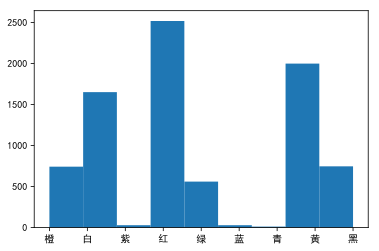

In [24]:
plt.figure()
plt.hist(a,bins=9)
plt.show()